# Plotting PCA results

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import xarray as xr
from sklearn.decomposition import PCA

## Load data

In [2]:
MVBS_PCP_path = '../data/'
MVBS_rpca_file = '20150817-20151017_MVBS_time_Sv_rangeBin5_all_corrected_rpca.nc'

In [3]:
MVBS_rpca = xr.open_dataset(os.path.join(MVBS_PCP_path, MVBS_rpca_file))
low_rank = MVBS_rpca['low_rank']
n_observations, n_frequencies, n_depth_levels, n_pings = low_rank.shape

In [4]:
low_rank = low_rank.values.reshape([n_observations,-1])

In [5]:
low_rank_nonneg = low_rank - low_rank.min()

In [6]:
low_rank_nonneg.shape

(62, 15984)

## Run PCA on data

In [7]:
model_PCA = PCA(svd_solver='full')
model_PCA.fit(low_rank_nonneg)

PCA(svd_solver='full')

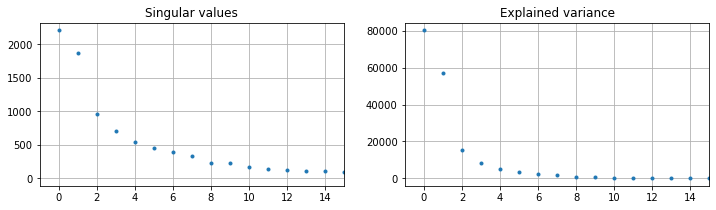

In [8]:
fig,ax = plt.subplots(1,2,figsize=(12,3))
ax[0].plot(model_PCA.singular_values_,'.')
ax[0].set_title('Singular values')
ax[0].set_xlim(-1,15)
ax[0].grid()
ax[1].plot(model_PCA.explained_variance_,'.')
ax[1].set_title('Explained variance')
ax[1].set_xlim(-1,15)
ax[1].grid()
plt.show()

### Check normalization

In [9]:
W_PCA = model_PCA.components_
H_PCA = model_PCA.fit_transform(low_rank_nonneg)

In [10]:
(W_PCA.shape, H_PCA.shape)

((62, 15984), (62, 62))

In [11]:
# Calculate norm for W and H
weights_W = np.linalg.norm(W_PCA, axis=1)
weights_H = np.linalg.norm(H_PCA.T,axis=0)
(weights_W.shape, weights_H.shape)

((62,), (62,))

In [12]:
(weights_W, weights_H)

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([278.66212749, 381.45001099, 497.3019365 , 547.58756196,
        583.58088279, 424.9269643 , 426.5113725 , 631.36305039,
        589.897248  , 507.4698314 , 445.20096398, 402.14709285,
        357.21230954, 288.38694362, 393.99613175, 350.6043334 ,
        299.33053443, 368.79597739, 452.68630105, 530.68735733,
        407.03068001, 433.03967449, 380.69532826, 280.3272372 ,
        264.65616131, 219.2006776 , 511.34378146, 639.34705165,
        326.67879261, 285.76145348, 322.15469482, 296.28474945,
        345.89804654, 435.66748916, 425.24509224, 198.60771347,
        327.93671102, 343.08053027, 334.55670099, 322.06709818,
        251.56935841, 519.44850982, 519.27258084, 429.06022353,
        233.05

We can see that all the weights are factored out to $\mathbf{H}$.

## Fig. S5. PCA results

Reshape PCA components back to daily echogram format.

In [13]:
components_PCA = np.array([W_PCA[x,:].reshape(n_frequencies*n_depth_levels,n_pings) 
                          for x in range(3)])
components_PCA.shape

(3, 111, 144)

Assemble dataset for activation so that it is easy to plot.

In [14]:
np.array(H_PCA).shape

(62, 62)

In [15]:
# Assemble dataset for activation
ds_activation = xr.Dataset(
    {
        'H_PCA': (['component', 'day'], np.array(H_PCA).T)
    },
    coords={
        'component': np.arange(62),
        'day': MVBS_rpca['low_rank'].date.values
    }
)

ds_activation

<xarray.Dataset>
Dimensions:    (component: 62, day: 62)
Coordinates:
  * component  (component) int64 0 1 2 3 4 5 6 7 8 ... 54 55 56 57 58 59 60 61
  * day        (day) datetime64[ns] 2015-08-17 2015-08-18 ... 2015-10-17
Data variables:
    H_PCA      (component, day) float64 -196.7 66.75 ... -2.869e-13 2.994e-13

Define some functions for plotting

In [16]:
def set_ax_ticks(ax):
    """Plot the tick marks for component panels
    """
    ax.set_xticks([])
    ax.set_yticks(np.arange(0,n_depth_levels*3+1,n_depth_levels))
    ax.set_yticklabels('')
    ax.grid(alpha=0.5)

In [17]:
def plot_daily_echogram_colorbar(ax1, ax2):
    pos_ax_left = ax1.get_position()
    pos_ax_right = ax2.get_position()
    cax = fig.add_axes([pos_ax_right.x0+pos_ax_right.width+0.012, 
                            pos_ax_left.y0, 
                            0.008, 
                            pos_ax_right.height])
    cbar = plt.colorbar(im, cax=cax)
#     cbar.set_ticks(np.arange(0,0.035,0.01))
    cbar.ax.tick_params(labelsize=tick_ls, pad=pad_size)
    return cbar

Change default color cycle for plotting activation sequences:

In [18]:
# Set custom color cycle
from cycler import cycler
# mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')  # default mpl color cycle
# plt.rcParams['axes.prop_cycle'] = cycler(color='cmbgryk')
# cmap = plt.cm.get_cmap('YlGnBu')
cmap = plt.cm.get_cmap('gray_r')
plt.rcParams['axes.prop_cycle'] = cycler(color=cmap([0.3,0.6,1.0]))

In [19]:
panel_ls=12
title_ls=10
freq_ls=8
comp_ls=8
axis_ls=8
legend_ls=6
tick_ls=8
pad_size=1

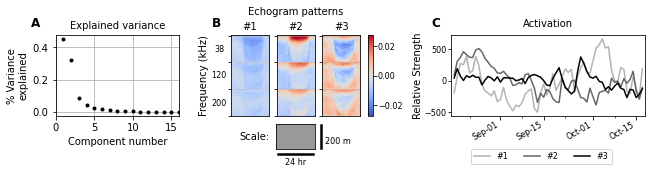

In [20]:
fig = plt.figure(figsize=(9,1.4))
gs_L = fig.add_gridspec(1,1, bottom=0.2, top=1.0, left=0.04, right=0.23, hspace=0.15)
gs_M = fig.add_gridspec(1,3, bottom=0.2, top=1.0, left=0.31,  right=0.51, hspace=0.15)
gs_R = fig.add_gridspec(1,1, bottom=0.2, top=1.0, left=0.65, right=0.95, hspace=0.15)


# PANEL: EIGENVALUES ============================================
ax_eigenvalue = fig.add_subplot(gs_L[0,0])
ax_eigenvalue.plot(np.arange(1,63), model_PCA.explained_variance_ratio_,'k.')
ax_eigenvalue.set_title('Explained variance', fontsize=title_ls)
ax_eigenvalue.set_xlim(0,16)
ax_eigenvalue.set_xlabel('Component number', fontsize=title_ls)
ax_eigenvalue.set_ylabel('% Variance\nexplained', fontsize=title_ls)
ax_eigenvalue.grid()


# PANEL: DAILY ECHOGRAM PATTERNS ================================
# vmin, vmax = (components_PCA.min(), components_PCA.max()*0.95)
vmax = np.abs([components_PCA.min(), components_PCA.max()]).max()*0.85
ax_echogram = []
for seq in range(3):  # loop through 3 components
    ax_echogram.append(fig.add_subplot(gs_M[0,seq]))
    im = ax_echogram[-1].imshow(components_PCA[seq,:,:], aspect='auto', 
                            vmin=-vmax, vmax=vmax, cmap='coolwarm')
    set_ax_ticks(ax_echogram[-1])
plot_daily_echogram_colorbar(ax_echogram[0], ax_echogram[2])

# Add frequency for echogram patterns
[
    fig.text(
        x=-0.3, y=yy, s=ss, transform=ax_echogram[0].transAxes,
        fontsize=freq_ls,
        ha='center', va='center')
    for ss,yy in zip(['200', '120', '38'], [0.15, 0.5, 0.825])
]

# Add echogram pattern labels
[ax_echogram[x-1].set_title('#%d' % x, fontsize=title_ls, pad=5) for x in np.arange(1,4,1)]


# PANEL: ACTIVATION COEFFICIENTS ================================
axa = fig.add_subplot(gs_R[0,0])
h1 = ds_activation.H_PCA.isel(component=slice(0,3)).\
        plot.line(x='day', ax=axa,
                  add_legend=False, _labels=False)
axa.xaxis.set_major_locator(
    mdates.MonthLocator(bymonth=range(8,11), bymonthday=[1,15]))
axa.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
axa.xaxis.set_minor_locator(mdates.AutoDateLocator())
axa.set_xlim([datetime.date(2015,8,16), datetime.date(2015,10,18)])
axa.set_title('')
# axa.set_xticklabels('')
axa.tick_params(labelsize=tick_ls, pad=pad_size)

# Add component legend
axa.legend(['#1', '#2', '#3'], 
              fontsize=tick_ls,
              bbox_to_anchor=(0.08, -0.65), 
              loc='lower left', ncol=3)


# Add panel labels
fig.text(x=-0.2,y=1.1,s='A',
         transform=ax_eigenvalue.transAxes,
         fontsize=panel_ls, fontweight='bold')
fig.text(x=-0.5,y=1.1,s='B',
         transform=ax_echogram[0].transAxes,
         fontsize=panel_ls, fontweight='bold')
fig.text(x=-0.1,y=1.1,s='C',
         transform=axa.transAxes,
         fontsize=panel_ls, fontweight='bold')

fig.text(x=-0.7, y=0.5, s='Frequency (kHz)', 
         transform=ax_echogram[0].transAxes,
         fontsize=title_ls, 
         rotation=90, ha='center', va='center')
fig.text(x=0.5,y=1.25,s='Echogram patterns',
         transform=ax_echogram[1].transAxes,
         fontsize=title_ls, ha='center')
fig.text(x=0.5,y=1.1,s='Activation',
         transform=axa.transAxes,
         fontsize=title_ls, ha='center')
fig.text(x=-0.17, y=0.5, s='Relative Strength', 
         transform=axa.transAxes,
         fontsize=title_ls, 
         rotation=90, ha='center', va='center')


# Add example axis for daily echogram patterns
gs_ex = fig.add_gridspec(1,1, bottom=-0.13, top=0.12, left=0.28+0.1, right=0.34+0.1)
ax_ex = fig.add_subplot(gs_ex[0,0])
ax_ex.set_xticks([])
ax_ex.set_yticks([])
ax_ex.set_facecolor(np.ones(3)*0.6)

trans = ax_ex.get_xaxis_transform()
ax_ex.plot([0,1],[-0.2,-0.2],  # add a line for horizontal scale
            color='k', lw=2.5, 
            transform=trans, clip_on=False)
ax_ex.annotate('24 hr',             # annotate
                xy=(0.2,-0.7), xycoords=trans, 
                ha='left', va='bottom', 
                fontsize=axis_ls)
trans = ax_ex.get_yaxis_transform()
ax_ex.plot([1.15,1.15],[0.2,1],  # add a line for vertical scale
            color='k', lw=2.5, 
            transform=trans, clip_on=False)
ax_ex.annotate('200 m',            # annotate
                xy=(1.6,0.6), xycoords=trans, 
                ha='center', va='top', rotation=0,
                fontsize=axis_ls)
fig.text(x=-0.55, y=0.5, s='Scale:', 
         transform=ax_ex.transAxes,
         fontsize=title_ls, 
         rotation=0, ha='center', va='center')

plt.show()

fig.savefig(os.path.join('../figs/fig_si_pca.png'),
            dpi=300, bbox_inches = 'tight', pad_inches = 0.05)